In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import mord as md

# Analysis with Ordinal Regression
In this notebook, the parsed data from FRC_Parser was analyzed using ordinal regression.  Before performing ordinal regression, some feature engineering was performed, particularly determining which features were important for each model.  For instance, for the defensive model, the autonomous features should be removed since one is penalized for touching any of the opposing alliance members during autonomous.  In addition, LASSO regularization was performed for variable selection and increased accuracy.  Finally, 

In [3]:
#Read the beta matrices into dataframes.
fileLoc = "C:\\Users\\Christian\\Documents\\GitHub\\FRC-Analyzer\\Parsed Output\\combStats_Off.csv"
temp = pd.read_csv(fileLoc,index_col=0)
beta_Off = temp.loc[:, temp.columns != 'rank']
rank_Off = temp.loc[:, temp.columns == 'rank']
print(beta_Off.columns.values)
beta_Off.head(10)

fileLoc = "C:\\Users\\Christian\\Documents\\GitHub\\FRC-Analyzer\\Parsed Output\\combStats_Def.csv"
temp = pd.read_csv(fileLoc,index_col=0)
beta_Def = temp.loc[:, temp.columns != 'rank']
rank_Def = temp.loc[:, temp.columns == 'rank']
beta_Def.head(10)
################################################################################################

['autoRobot.None' 'autoRobot.AutoRun' 'endgameRobot.None'
 'endgameRobot.Parking' 'endgameRobot.Climbing' 'endgameRobot.Levitate'
 'endgameRobot.Unknown' 'adjustPoints' 'autoOwnershipPoints' 'autoPoints'
 'autoQuestRankingPoint' 'autoRunPoints' 'autoScaleOwnershipSec'
 'autoSwitchAtZero' 'autoSwitchOwnershipSec' 'endgamePoints'
 'faceTheBossRankingPoint' 'foulCount' 'foulPoints' 'rp'
 'tba_gameData_LLL' 'tba_gameData_LRL' 'tba_gameData_RLR'
 'tba_gameData_RRR' 'techFoulCount' 'teleopOwnershipPoints' 'teleopPoints'
 'teleopScaleBoostSec' 'teleopScaleForceSec' 'teleopScaleOwnershipSec'
 'teleopSwitchBoostSec' 'teleopSwitchForceSec' 'teleopSwitchOwnershipSec'
 'totalPoints' 'vaultBoostPlayed' 'vaultBoostTotal' 'vaultForcePlayed'
 'vaultForceTotal' 'vaultLevitatePlayed' 'vaultLevitateTotal'
 'vaultPoints']


,autoRobot.None,autoRobot.AutoRun,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,endgameRobot.Unknown,adjustPoints,autoOwnershipPoints,autoPoints,...,teleopSwitchForceSec,teleopSwitchOwnershipSec,totalPoints,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal,vaultPoints
frc1011,0,9,2,3,1,3,0,0.0,-5.988145,-2.374308,...,-0.901581,-27.794169,-22.561678,-0.662202,-0.381198,-0.236885,-0.373498,0.283035,0.524452,-1.151219
frc1138,1,8,1,4,3,1,0,0.0,0.436460,3.160595,...,1.222854,29.131349,81.196106,0.188735,0.344464,0.155470,0.049086,0.371053,0.549780,4.716653
frc1165,1,8,1,7,0,1,0,0.0,6.388329,10.480164,...,-0.474478,57.903979,140.047780,0.765376,0.924305,0.601972,0.767460,0.575086,0.651302,11.715333
frc1492,0,9,0,7,0,2,0,0.0,2.056842,7.083684,...,-1.115645,44.373917,75.942624,0.199561,0.012820,-0.397862,-0.490965,0.756782,0.582581,0.522178
frc1828,6,3,8,0,0,1,0,0.0,-2.011112,2.479637,...,-0.415867,18.152114,42.574413,1.034487,0.955254,0.293551,0.233334,0.234063,0.481079,8.348335
frc1836,0,9,0,2,2,5,0,0.0,11.344820,15.585831,...,1.168729,3.338760,94.438884,-0.025984,-0.333536,0.333031,0.339061,1.309536,1.495913,7.507188
frc2073,6,3,5,2,0,2,0,0.0,2.000373,5.832667,...,0.618798,33.571822,82.708019,-0.089901,-0.031341,0.023829,0.409366,0.878854,0.934896,6.564601
frc2122,0,9,0,5,0,4,0,0.0,-0.697102,3.067424,...,1.696737,16.245898,-5.387790,-0.453328,-0.218019,0.132231,0.200603,-0.305594,0.026230,0.044069
frc2135,1,8,2,6,1,0,0,0.0,2.230771,6.941917,...,2.577232,56.916077,118.974836,0.637752,0.792226,0.720276,0.722077,1.139685,1.028528,12.714157
frc2375,2,7,2,4,0,3,0,0.0,-0.079743,3.580586,...,-1.023239,29.589669,65.234041,1.013812,1.424926,-0.145726,-0.290522,-0.059801,0.003751,5.690776


## Feature Engineering

### Offensive Beta Matrix

In [4]:
#Compress autoRobot and endgameRobot features by normalizing them 
#and removing one of the features.  This is due to the fact that 
#these columns would be highly correlated to each other.

#Normalized autoRobot.AutoRun and removed autoRobot.None
autoRobotTotal = beta_Off["autoRobot.None"]+beta_Off["autoRobot.AutoRun"]
beta_Off["autoRobot.AutoRun"] = beta_Off["autoRobot.AutoRun"]/autoRobotTotal
beta_Off = beta_Off.drop("autoRobot.None", axis=1)

#Normalized endgameRobot.None; .Parking; .Climbing; .Levitate; 
#and removed endgameRobot.Unknown
endgameFeatures = ["endgameRobot.None",\
                   "endgameRobot.Parking",\
                   "endgameRobot.Climbing",\
                   "endgameRobot.Levitate",\
                   "endgameRobot.Unknown"]
endgameRobotTotal = pd.DataFrame(0, index=beta_Off.index, columns=[""])

for i in range(len(endgameFeatures)):
    endgameRobotTotal[""] = endgameRobotTotal[""]+beta_Off[endgameFeatures[i]]

for i in range(len(endgameFeatures)):
    beta_Off[endgameFeatures[i]] = beta_Off[endgameFeatures[i]]/endgameRobotTotal[""]

beta_Off = beta_Off.drop("endgameRobot.Unknown", axis=1)
beta_Off.head(10)
################################################################################################

,autoRobot.AutoRun,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,adjustPoints,autoOwnershipPoints,autoPoints,autoQuestRankingPoint,autoRunPoints,...,teleopSwitchForceSec,teleopSwitchOwnershipSec,totalPoints,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal,vaultPoints
frc1011,1.000000,0.222222,0.333333,0.111111,0.333333,0.0,14.061050,19.529943,0.418078,5.468893,...,3.073752,61.616366,152.634139,0.819300,1.612800,1.000296,1.294342,0.802401,1.010959,19.590503
frc1138,0.888889,0.111111,0.444444,0.333333,0.111111,0.0,2.540135,6.025926,0.009494,3.485791,...,-0.181966,53.862923,95.355040,-0.223595,-0.025423,0.102514,0.002072,0.891218,0.788343,3.824961
frc1165,0.888889,0.111111,0.777778,0.000000,0.111111,0.0,-0.173816,4.281160,0.083629,4.454977,...,0.156584,32.382217,65.601853,-0.423015,-0.122933,0.342868,0.361869,0.815491,0.925543,5.822393
frc1492,1.000000,0.000000,0.777778,0.000000,0.222222,0.0,1.461584,5.146033,0.119050,3.684450,...,3.615618,45.427381,115.094639,1.059184,1.231078,0.953151,0.816711,1.580516,1.523221,17.855047
frc1828,0.333333,0.888889,0.000000,0.000000,0.111111,0.0,-2.526500,0.130574,-0.327486,2.657074,...,-1.875954,28.842826,39.806408,-0.125440,0.144217,-0.355597,-0.253245,-0.864786,-0.183077,-1.460525
frc1836,1.000000,0.000000,0.222222,0.222222,0.555556,0.0,17.469703,23.014768,0.552374,5.545065,...,1.194950,61.205781,145.667117,0.528823,0.681758,0.519382,0.824608,1.424517,1.325751,14.160586
frc2073,0.333333,0.555556,0.222222,0.000000,0.222222,0.0,4.603082,4.774657,-0.473716,0.171575,...,-0.845728,60.522164,90.668577,0.247194,0.186630,0.219981,0.191550,0.332616,0.747636,5.629083
frc2122,1.000000,0.000000,0.555556,0.000000,0.444444,0.0,15.353849,20.186474,0.435562,4.832625,...,1.086317,51.886926,189.911517,0.987938,1.233905,0.284638,0.133180,1.431451,1.286385,13.267346
frc2135,0.888889,0.222222,0.666667,0.111111,0.000000,0.0,1.109949,5.949875,-0.023269,4.839926,...,3.765769,49.111438,99.739467,0.649438,0.827798,0.959046,1.279495,1.375982,1.278130,16.927117
frc2375,0.777778,0.222222,0.444444,0.000000,0.333333,0.0,-0.728076,4.834168,0.085126,5.562244,...,2.416542,30.036936,84.686037,0.656700,0.849532,0.473795,1.032729,0.530837,0.759829,13.210447


In [5]:
#Remove point-related features since this information is already captured by the direct features
#that are captured by the other features.  For instance, the sum of all the vault totals 
#(vaultBoostTotal, vaultForceTotal, and vaultLevitateTotal) are 1/5 the vaultPoints feature

pointFeatures = ["autoOwnershipPoints",\
                 "autoPoints",\
                 "autoQuestRankingPoint",\
                 "endgamePoints",\
                 "rp",\
                 "teleopOwnershipPoints",\
                 "teleopPoints",\
                 "totalPoints",\
                 "vaultPoints"]
beta_Off = beta_Off.drop(pointFeatures, axis=1)
beta_Off.head(10)
################################################################################################

,autoRobot.AutoRun,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,adjustPoints,autoRunPoints,autoScaleOwnershipSec,autoSwitchAtZero,autoSwitchOwnershipSec,...,teleopScaleOwnershipSec,teleopSwitchBoostSec,teleopSwitchForceSec,teleopSwitchOwnershipSec,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal
frc1011,1.000000,0.222222,0.333333,0.111111,0.333333,0.0,5.468893,-0.280953,0.533906,7.311478,...,34.521089,3.602187,3.073752,61.616366,0.819300,1.612800,1.000296,1.294342,0.802401,1.010959
frc1138,0.888889,0.111111,0.444444,0.333333,0.111111,0.0,3.485791,-0.023728,0.043063,1.293796,...,-0.154738,0.336704,-0.181966,53.862923,-0.223595,-0.025423,0.102514,0.002072,0.891218,0.788343
frc1165,0.888889,0.111111,0.777778,0.000000,0.111111,0.0,4.454977,-0.424866,0.122428,0.337958,...,13.083207,0.476944,0.156584,32.382217,-0.423015,-0.122933,0.342868,0.361869,0.815491,0.925543
frc1492,1.000000,0.000000,0.777778,0.000000,0.222222,0.0,3.684450,-0.009583,0.101713,0.740374,...,33.897456,5.177125,3.615618,45.427381,1.059184,1.231078,0.953151,0.816711,1.580516,1.523221
frc1828,0.333333,0.888889,0.000000,0.000000,0.111111,0.0,2.657074,-0.046856,-0.202140,-1.216394,...,3.109105,1.906313,-1.875954,28.842826,-0.125440,0.144217,-0.355597,-0.253245,-0.864786,-0.183077
frc1836,1.000000,0.000000,0.222222,0.222222,0.555556,0.0,5.545065,0.183521,0.742215,8.551330,...,-1.556240,2.496427,1.194950,61.205781,0.528823,0.681758,0.519382,0.824608,1.424517,1.325751
frc2073,0.333333,0.555556,0.222222,0.000000,0.222222,0.0,0.171575,0.440729,0.192986,1.860812,...,11.098086,4.814092,-0.845728,60.522164,0.247194,0.186630,0.219981,0.191550,0.332616,0.747636
frc2122,1.000000,0.000000,0.555556,0.000000,0.444444,0.0,4.832625,3.685870,0.327636,3.991054,...,68.946158,4.007793,1.086317,51.886926,0.987938,1.233905,0.284638,0.133180,1.431451,1.286385
frc2135,0.888889,0.222222,0.666667,0.111111,0.000000,0.0,4.839926,-0.467845,0.028201,1.022820,...,0.943917,2.093752,3.765769,49.111438,0.649438,0.827798,0.959046,1.279495,1.375982,1.278130
frc2375,0.777778,0.222222,0.444444,0.000000,0.333333,0.0,5.562244,-0.074559,0.018951,-0.289479,...,14.085477,0.476216,2.416542,30.036936,0.656700,0.849532,0.473795,1.032729,0.530837,0.759829


### Defensive Beta Matrix

In [6]:
#Remove the autoRobot specific variables since they do not add to the defensive description of 
#game.  In addition, there is a penalty for interferring with an opposing robot's autonomous, so
#these robot specific variables should be removed
autoRobotFeats = ["autoRobot.None","autoRobot.AutoRun"]
beta_Def = beta_Def.drop(autoRobotFeats, axis=1)
beta_Def.head(10)
################################################################################################

,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,endgameRobot.Unknown,adjustPoints,autoOwnershipPoints,autoPoints,autoQuestRankingPoint,autoRunPoints,...,teleopSwitchForceSec,teleopSwitchOwnershipSec,totalPoints,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal,vaultPoints
frc1011,2,3,1,3,0,0.0,-5.988145,-2.374308,-0.331604,3.613837,...,-0.901581,-27.794169,-22.561678,-0.662202,-0.381198,-0.236885,-0.373498,0.283035,0.524452,-1.151219
frc1138,1,4,3,1,0,0.0,0.436460,3.160595,-0.181806,2.724136,...,1.222854,29.131349,81.196106,0.188735,0.344464,0.155470,0.049086,0.371053,0.549780,4.716653
frc1165,1,7,0,1,0,0.0,6.388329,10.480164,0.188940,4.091835,...,-0.474478,57.903979,140.047780,0.765376,0.924305,0.601972,0.767460,0.575086,0.651302,11.715333
frc1492,0,7,0,2,0,0.0,2.056842,7.083684,-0.041089,5.026841,...,-1.115645,44.373917,75.942624,0.199561,0.012820,-0.397862,-0.490965,0.756782,0.582581,0.522178
frc1828,8,0,0,1,0,0.0,-2.011112,2.479637,0.178363,4.490749,...,-0.415867,18.152114,42.574413,1.034487,0.955254,0.293551,0.233334,0.234063,0.481079,8.348335
frc1836,0,2,2,5,0,0.0,11.344820,15.585831,0.381239,4.241011,...,1.168729,3.338760,94.438884,-0.025984,-0.333536,0.333031,0.339061,1.309536,1.495913,7.507188
frc2073,5,2,0,2,0,0.0,2.000373,5.832667,-0.070889,3.832295,...,0.618798,33.571822,82.708019,-0.089901,-0.031341,0.023829,0.409366,0.878854,0.934896,6.564601
frc2122,0,5,0,4,0,0.0,-0.697102,3.067424,0.079967,3.764527,...,1.696737,16.245898,-5.387790,-0.453328,-0.218019,0.132231,0.200603,-0.305594,0.026230,0.044069
frc2135,2,6,1,0,0,0.0,2.230771,6.941917,0.253126,4.711146,...,2.577232,56.916077,118.974836,0.637752,0.792226,0.720276,0.722077,1.139685,1.028528,12.714157
frc2375,2,4,0,3,0,0.0,-0.079743,3.580586,0.317489,3.660329,...,-1.023239,29.589669,65.234041,1.013812,1.424926,-0.145726,-0.290522,-0.059801,0.003751,5.690776


In [7]:
#Compress endgameRobot features by normalizing them and removing one of the features.
#This is due to the fact that this column would be highly correlated to each other.

#Normalized endgameRobot.None; .Parking; .Climbing; .Levitate; and removed endgameRobot.Unknown

#Endgame features list has already been made in the offensive portion.  This is just here for 
#symmetry purposes.
#-----------------------------------------------------------------------------------------------
#endgameFeatures = ["endgameRobot.None",\
#                   "endgameRobot.Parking",\
#                   "endgameRobot.Climbing",\
#                   "endgameRobot.Levitate",\
#                   "endgameRobot.Unknown"]
endgameRobotTotal = pd.DataFrame(0, index=beta_Def.index, columns=[""])

for i in range(len(endgameFeatures)):
    endgameRobotTotal[""] = endgameRobotTotal[""]+beta_Def[endgameFeatures[i]]

for i in range(len(endgameFeatures)):
    beta_Def[endgameFeatures[i]] = beta_Def[endgameFeatures[i]]/endgameRobotTotal[""]

beta_Def = beta_Def.drop("endgameRobot.Unknown", axis=1)
beta_Def.head(10)
################################################################################################

,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,adjustPoints,autoOwnershipPoints,autoPoints,autoQuestRankingPoint,autoRunPoints,autoScaleOwnershipSec,...,teleopSwitchForceSec,teleopSwitchOwnershipSec,totalPoints,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal,vaultPoints
frc1011,0.222222,0.333333,0.111111,0.333333,0.0,-5.988145,-2.374308,-0.331604,3.613837,-0.249298,...,-0.901581,-27.794169,-22.561678,-0.662202,-0.381198,-0.236885,-0.373498,0.283035,0.524452,-1.151219
frc1138,0.111111,0.444444,0.333333,0.111111,0.0,0.436460,3.160595,-0.181806,2.724136,-0.489170,...,1.222854,29.131349,81.196106,0.188735,0.344464,0.155470,0.049086,0.371053,0.549780,4.716653
frc1165,0.111111,0.777778,0.000000,0.111111,0.0,6.388329,10.480164,0.188940,4.091835,0.502311,...,-0.474478,57.903979,140.047780,0.765376,0.924305,0.601972,0.767460,0.575086,0.651302,11.715333
frc1492,0.000000,0.777778,0.000000,0.222222,0.0,2.056842,7.083684,-0.041089,5.026841,1.763886,...,-1.115645,44.373917,75.942624,0.199561,0.012820,-0.397862,-0.490965,0.756782,0.582581,0.522178
frc1828,0.888889,0.000000,0.000000,0.111111,0.0,-2.011112,2.479637,0.178363,4.490749,-0.590447,...,-0.415867,18.152114,42.574413,1.034487,0.955254,0.293551,0.233334,0.234063,0.481079,8.348335
frc1836,0.000000,0.222222,0.222222,0.555556,0.0,11.344820,15.585831,0.381239,4.241011,1.393394,...,1.168729,3.338760,94.438884,-0.025984,-0.333536,0.333031,0.339061,1.309536,1.495913,7.507188
frc2073,0.555556,0.222222,0.000000,0.222222,0.0,2.000373,5.832667,-0.070889,3.832295,-0.018829,...,0.618798,33.571822,82.708019,-0.089901,-0.031341,0.023829,0.409366,0.878854,0.934896,6.564601
frc2122,0.000000,0.555556,0.000000,0.444444,0.0,-0.697102,3.067424,0.079967,3.764527,-0.781538,...,1.696737,16.245898,-5.387790,-0.453328,-0.218019,0.132231,0.200603,-0.305594,0.026230,0.044069
frc2135,0.222222,0.666667,0.111111,0.000000,0.0,2.230771,6.941917,0.253126,4.711146,-0.358886,...,2.577232,56.916077,118.974836,0.637752,0.792226,0.720276,0.722077,1.139685,1.028528,12.714157
frc2375,0.222222,0.444444,0.000000,0.333333,0.0,-0.079743,3.580586,0.317489,3.660329,-0.459810,...,-1.023239,29.589669,65.234041,1.013812,1.424926,-0.145726,-0.290522,-0.059801,0.003751,5.690776


In [8]:
#Remove point-related features since this information is already captured by the direct features
#that are captured by the other features.  For instance, the sum of all the vault totals 
#(vaultBoostTotal, vaultForceTotal, and vaultLevitateTotal) are 1/5 the vaultPoints feature

#Point features list has already been made in the offensive portion.  This is just here for 
#symmetry purposes.
#-----------------------------------------------------------------------------------------------
#pointFeatures = ["autoOwnershipPoints",\
#                 "autoPoints",\
#                 "autoQuestRankingPoint",\
#                 "endgamePoints",\
#                 "rp",\
#                 "teleopOwnershipPoints",\
#                 "teleopPoints",\
#                 "totalPoints",\
#                 "vaultPoints"]
beta_Def = beta_Def.drop(pointFeatures, axis=1)
beta_Def.head(10)

,endgameRobot.None,endgameRobot.Parking,endgameRobot.Climbing,endgameRobot.Levitate,adjustPoints,autoRunPoints,autoScaleOwnershipSec,autoSwitchAtZero,autoSwitchOwnershipSec,faceTheBossRankingPoint,...,teleopScaleOwnershipSec,teleopSwitchBoostSec,teleopSwitchForceSec,teleopSwitchOwnershipSec,vaultBoostPlayed,vaultBoostTotal,vaultForcePlayed,vaultForceTotal,vaultLevitatePlayed,vaultLevitateTotal
frc1011,0.222222,0.333333,0.111111,0.333333,0.0,3.613837,-0.249298,-0.225954,-2.744774,-0.013470,...,5.982403,-2.676607,-0.901581,-27.794169,-0.662202,-0.381198,-0.236885,-0.373498,0.283035,0.524452
frc1138,0.111111,0.444444,0.333333,0.111111,0.0,2.724136,-0.489170,0.038812,0.707400,-0.034479,...,34.341964,-0.269760,1.222854,29.131349,0.188735,0.344464,0.155470,0.049086,0.371053,0.549780
frc1165,0.111111,0.777778,0.000000,0.111111,0.0,4.091835,0.502311,0.327683,2.691854,0.186822,...,32.928165,0.607386,-0.474478,57.903979,0.765376,0.924305,0.601972,0.767460,0.575086,0.651302
frc1492,0.000000,0.777778,0.000000,0.222222,0.0,5.026841,1.763886,0.073755,-0.735465,0.033902,...,7.626840,0.364301,-1.115645,44.373917,0.199561,0.012820,-0.397862,-0.490965,0.756782,0.582581
frc1828,0.888889,0.000000,0.000000,0.111111,0.0,4.490749,-0.590447,-0.007280,-0.415109,-0.031072,...,14.761842,1.834987,-0.415867,18.152114,1.034487,0.955254,0.293551,0.233334,0.234063,0.481079
frc1836,0.000000,0.222222,0.222222,0.555556,0.0,4.241011,1.393394,0.533722,4.279015,0.086066,...,42.553994,0.720100,1.168729,3.338760,-0.025984,-0.333536,0.333031,0.339061,1.309536,1.495913
frc2073,0.555556,0.222222,0.000000,0.222222,0.0,3.832295,-0.018829,0.112175,1.019015,-0.037328,...,14.727644,1.636218,0.618798,33.571822,-0.089901,-0.031341,0.023829,0.409366,0.878854,0.934896
frc2122,0.000000,0.555556,0.000000,0.444444,0.0,3.764527,-0.781538,0.012568,0.432987,-0.003727,...,-22.032498,-0.246978,1.696737,16.245898,-0.453328,-0.218019,0.132231,0.200603,-0.305594,0.026230
frc2135,0.222222,0.666667,0.111111,0.000000,0.0,4.711146,-0.358886,0.279737,1.474272,-0.041572,...,27.073109,0.289543,2.577232,56.916077,0.637752,0.792226,0.720276,0.722077,1.139685,1.028528
frc2375,0.222222,0.444444,0.000000,0.333333,0.0,3.660329,-0.459810,0.158483,0.419938,-0.079166,...,25.728997,0.738134,-1.023239,29.589669,1.013812,1.424926,-0.145726,-0.290522,-0.059801,0.003751


## Correlation Plots

### Offensive Correlation Matrix

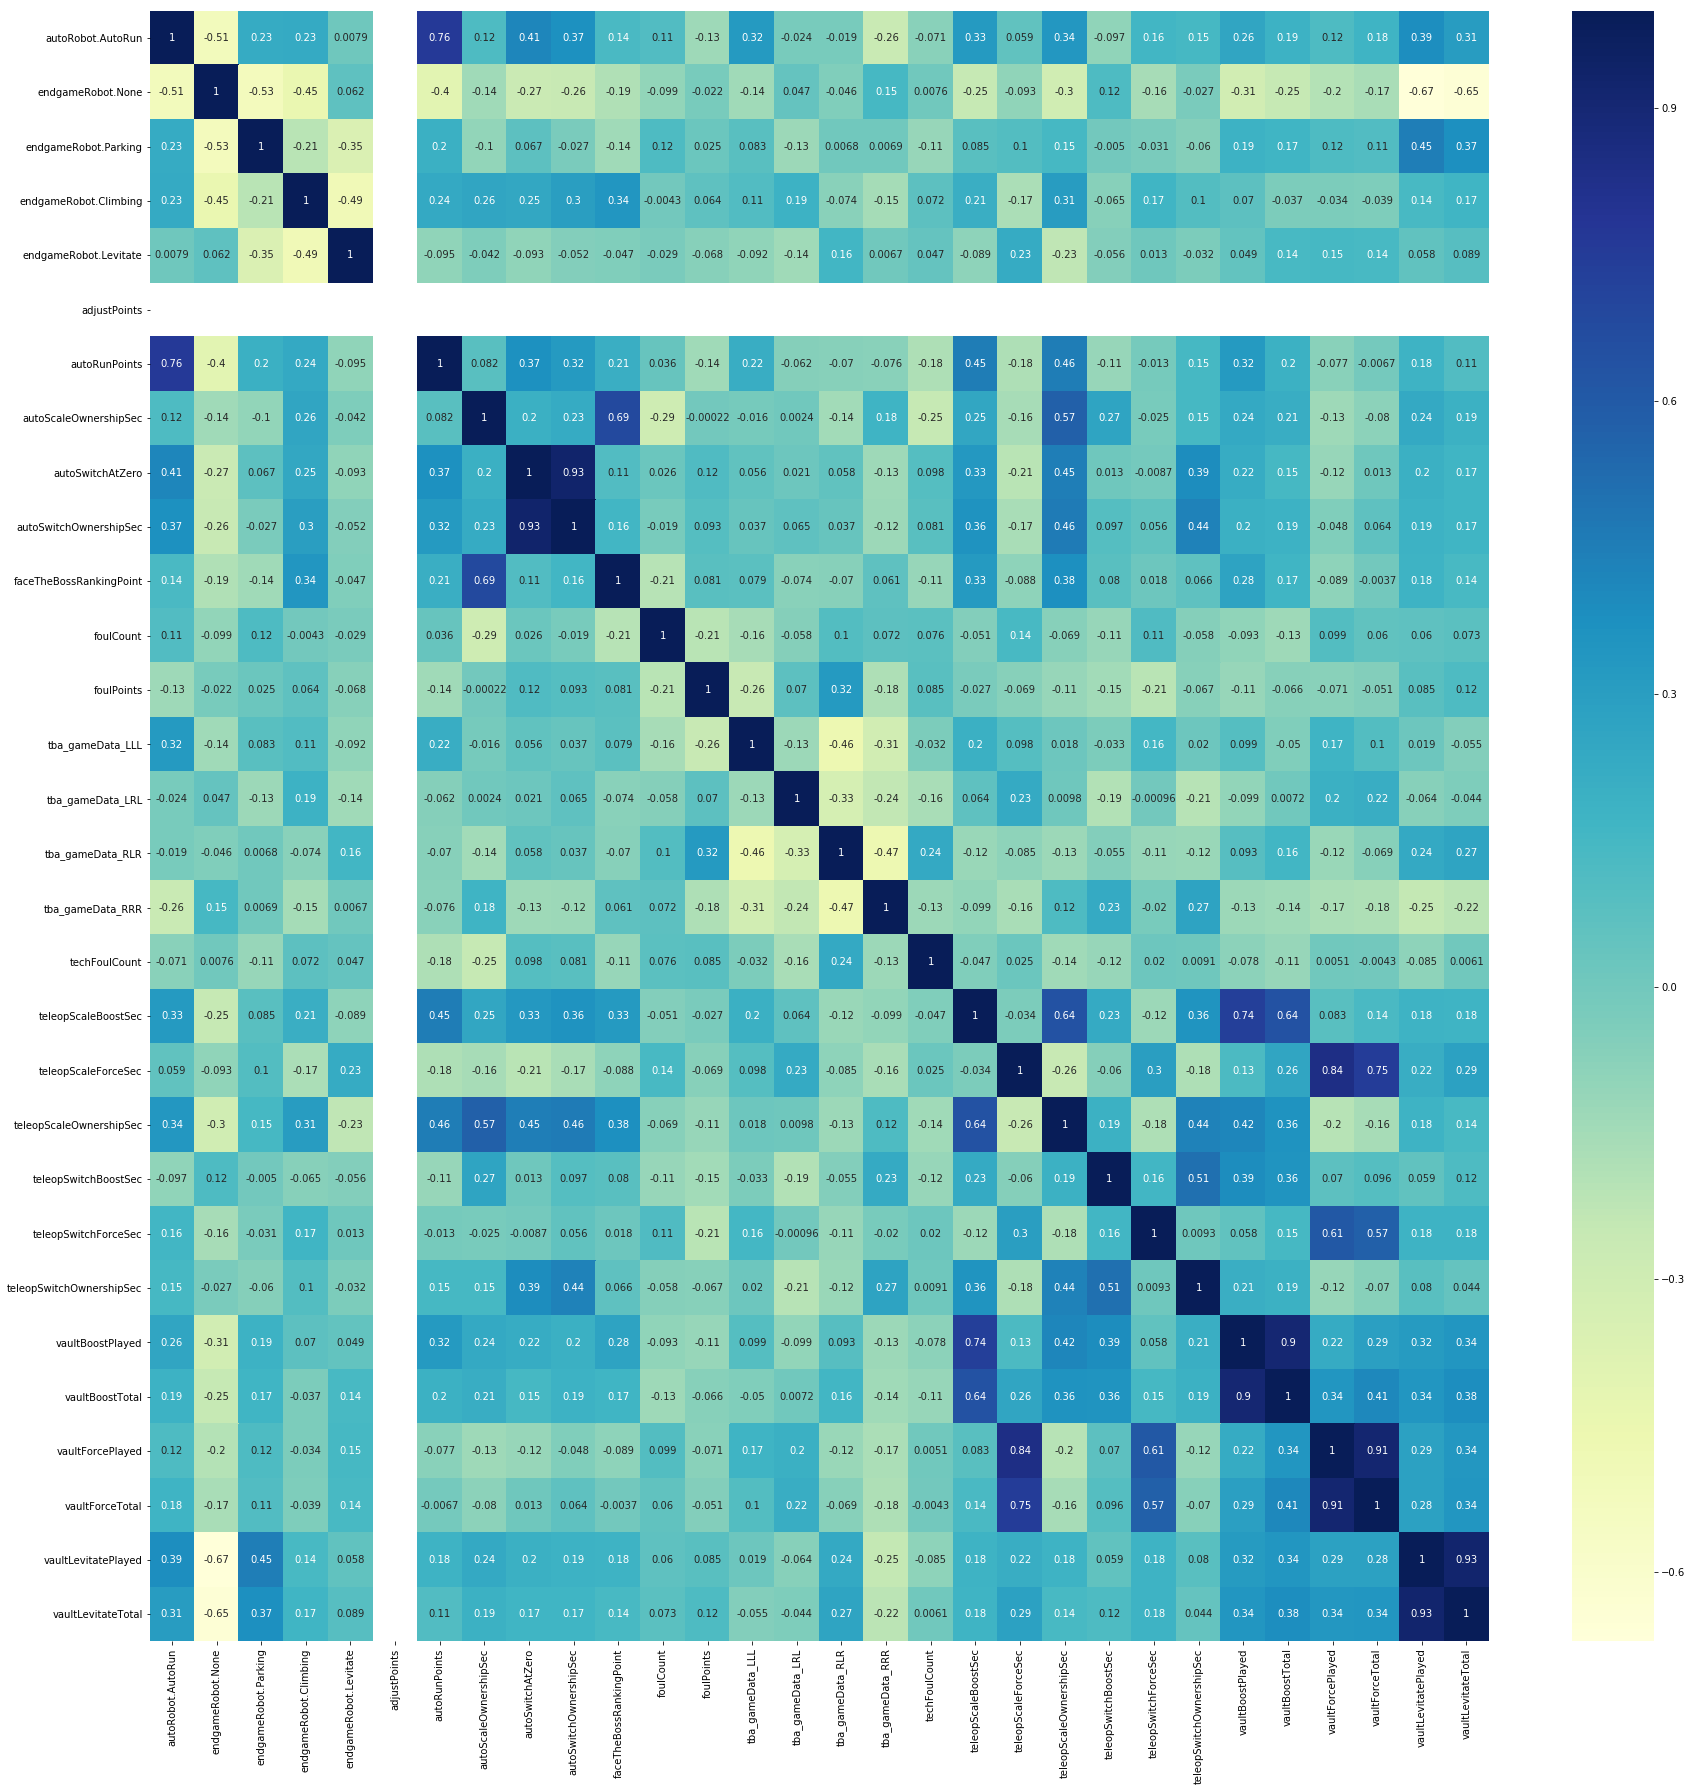

In [9]:
#Correlation matrix for offense beta matrix
fig, ax = plt.subplots(figsize=(30, 30))
# pass the axis to draw on
corr = beta_Off.corr()
sns.heatmap(corr, ax=ax, cmap="YlGnBu", annot=True)
################################################################################################

### Defensive Correlation Matrix

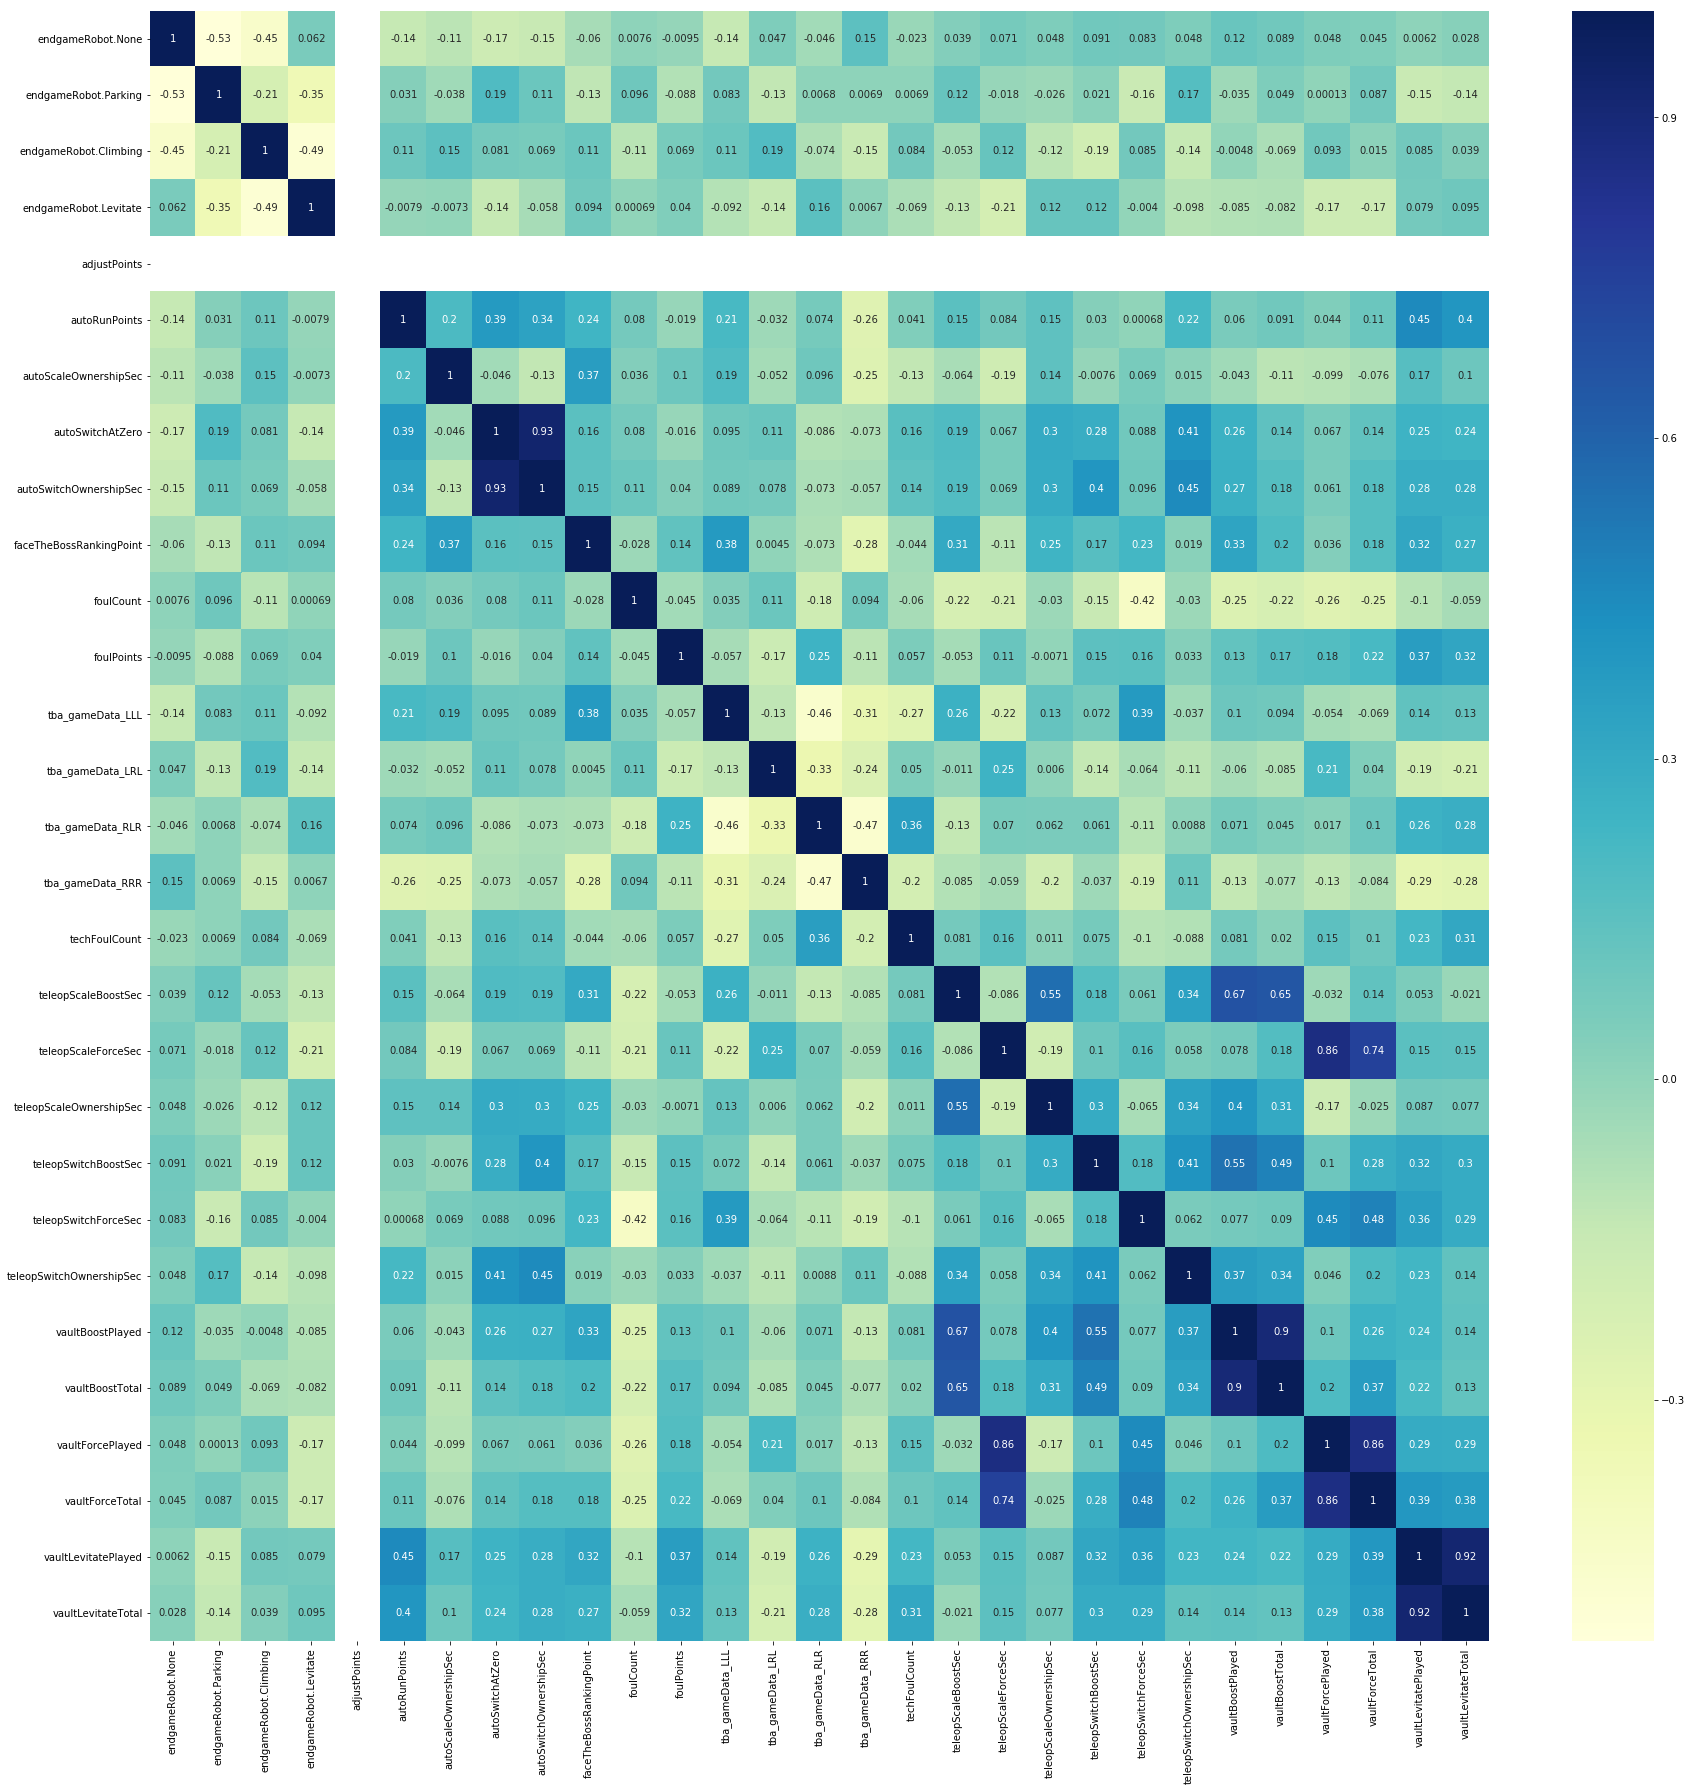

In [10]:
#Correlation matrix for defense beta matrix
fig, ax = plt.subplots(figsize=(30, 30))
# pass the axis to draw on
corr = beta_Def.corr()
sns.heatmap(corr, ax=ax, cmap="YlGnBu", annot=True)
################################################################################################

## Strongest Absolute Correlations

In [11]:
#Functions to list the largest correlations
def get_redundant_pairs(corr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = corr.columns
    for i in range(0, corr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n=5):
    au_corr = pd.Series(corr.abs().unstack(), name='Abs')
    sign_corr = np.sign(corr)
    si_corr = pd.Series(sign_corr.unstack(), name='Sign')
    
    labels_to_drop = get_redundant_pairs(corr)
    
    au_corr = au_corr.drop(labels=labels_to_drop)
    si_corr = si_corr.drop(labels=labels_to_drop)
    
    corr_Val_Sign = pd.concat([au_corr,si_corr], axis=1)
    corr_Val_Sign = corr_Val_Sign.sort_values(by='Abs',ascending=False)    
    return corr_Val_Sign[0:n].Abs*corr_Val_Sign[0:n].Sign
################################################################################################

In [12]:
#Removed "adjustPoints" from beta matrices
beta_Off = beta_Off.drop(['adjustPoints'], axis=1)
beta_Def = beta_Def.drop(['adjustPoints'], axis=1)
corr_Off = beta_Off.corr()
corr_Def = beta_Def.corr()

print("-------------------------------------")
print("-Top Absolute Correlations (Offense)-")
print("-------------------------------------")
print(get_top_abs_correlations(corr_Off, 1000))

print("-------------------------------------")
print("-Top Absolute Correlations (Defense)-")
print("-------------------------------------")
print(get_top_abs_correlations(corr_Def, 1000))
################################################################################################

-------------------------------------
-Top Absolute Correlations (Offense)-
-------------------------------------
autoSwitchAtZero         autoSwitchOwnershipSec      0.929128
vaultLevitatePlayed      vaultLevitateTotal          0.925776
vaultForcePlayed         vaultForceTotal             0.910574
vaultBoostPlayed         vaultBoostTotal             0.904947
teleopScaleForceSec      vaultForcePlayed            0.837265
autoRobot.AutoRun        autoRunPoints               0.762979
teleopScaleForceSec      vaultForceTotal             0.748189
teleopScaleBoostSec      vaultBoostPlayed            0.735842
autoScaleOwnershipSec    faceTheBossRankingPoint     0.686454
endgameRobot.None        vaultLevitatePlayed        -0.671113
                         vaultLevitateTotal         -0.649637
teleopScaleBoostSec      teleopScaleOwnershipSec     0.639395
                         vaultBoostTotal             0.636183
teleopSwitchForceSec     vaultForcePlayed            0.614234
autoScaleOwnership

## Variance Inflation Factors
If features have VIFs larger than 10, then multicollinearity needs to be addressed.

### Offensive VIFs

In [13]:
#Calculate the VIF for the offensive beta matrix
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(beta_Off.values, i) \
                     for i in range(beta_Off.shape[1])]
vif["features"] = beta_Off.columns
vif.head(100)
################################################################################################

,VIF Factor,features
0,4.859713,autoRobot.AutoRun
1,130.566009,endgameRobot.None
2,151.708588,endgameRobot.Parking
3,159.465885,endgameRobot.Climbing
4,98.439858,endgameRobot.Levitate
5,4.852820,autoRunPoints
6,5.312506,autoScaleOwnershipSec
7,15.536639,autoSwitchAtZero
8,13.740825,autoSwitchOwnershipSec
9,3.572862,faceTheBossRankingPoint


### Defensive VIFs

In [14]:
#Calculate the VIF for the defensive beta matrix
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(beta_Def.values, i) \
                     for i in range(beta_Def.shape[1])]
vif["features"] = beta_Def.columns
vif.head(100)
################################################################################################

,VIF Factor,features
0,108.075986,endgameRobot.None
1,121.957357,endgameRobot.Parking
2,129.473219,endgameRobot.Climbing
3,80.116322,endgameRobot.Levitate
4,2.217742,autoRunPoints
5,1.723596,autoScaleOwnershipSec
6,14.984739,autoSwitchAtZero
7,14.708167,autoSwitchOwnershipSec
8,2.280680,faceTheBossRankingPoint
9,1.996313,foulCount


## Principle Component Analysis (PCA)

In [15]:

scaler = StandardScaler()

# Standardize the data
scaler.fit(beta_Off)

# Apply transform to data
beta_Off_Scaled = scaler.transform(beta_Off)
################################################################################################

In [16]:
pca = PCA(.95)
pca.fit(beta_Off_Scaled)
print(pca.components_)
beta_Off_PCA = pd.DataFrame(data = pca.fit_transform(beta_Off_Scaled),\
                            index=beta_Off.index.values)

#Change the headers on beta_Off_PCA
beta_Off_PCA = beta_Off_PCA.rename(columns=lambda x: 'ortho'+str(x))

beta_Off_PCA.head(100)
################################################################################################

[[ 2.71677751e-01 -2.83814249e-01  1.34992598e-01  1.58640292e-01
  -3.81431206e-02  2.41541055e-01  1.79349372e-01  2.33297031e-01
   2.39196681e-01  1.71579773e-01 -1.46223842e-02 -1.92405446e-02
   8.68305126e-02 -2.92666396e-03  2.91315373e-03 -8.23788993e-02
  -4.82771396e-02  2.96681627e-01  4.89366136e-02  2.72474079e-01
   1.02591889e-01  8.44228132e-02  1.51796887e-01  3.01762725e-01
   2.78639498e-01  1.17076853e-01  1.46668605e-01  2.72892416e-01
   2.61164414e-01]
 [ 4.20663587e-03 -7.65391144e-02  9.76738831e-02 -1.23855944e-01
   1.38768523e-01 -1.25008024e-01 -1.91722938e-01 -1.75689069e-01
  -1.64001793e-01 -1.47393478e-01  9.76901424e-02 -2.57060918e-02
   3.50903959e-02  7.82130414e-02  4.90421346e-02 -1.46097145e-01
   3.40269433e-02 -1.06764584e-01  4.14721453e-01 -2.68807905e-01
  -4.91390739e-02  2.55474225e-01 -1.91114559e-01  3.33974501e-02
   1.08860787e-01  4.29626919e-01  3.91992471e-01  1.63983543e-01
   1.94173101e-01]
 [-1.80195925e-01  2.65165085e-01 -1.7

,ortho0,ortho1,ortho2,ortho3,ortho4,ortho5,ortho6,ortho7,ortho8,ortho9,ortho10,ortho11,ortho12,ortho13,ortho14,ortho15,ortho16
frc1011,4.102746,1.936791,2.485817,0.699681,0.737094,-3.153251,-0.401796,-1.296558,1.104755,0.020201,-1.179523,-0.116558,-0.120233,0.411311,0.342451,-0.017847,-0.068302
frc1138,-0.968855,-0.437785,-1.858009,0.094258,1.384519,0.572554,0.016460,-0.505108,-0.964425,-1.369646,-1.073155,-0.611955,-1.202965,-0.596044,0.829740,0.855268,-0.127201
frc1165,-1.338834,0.893588,-1.075682,1.415561,-2.162882,0.946861,-1.487491,-1.518925,1.247518,0.055733,0.458153,-0.009113,0.431779,-0.608543,0.514622,-0.420519,0.039723
frc1492,3.392228,3.899340,0.805031,-1.106996,-2.303088,-0.347491,-0.748521,0.037438,-1.736114,0.368793,-1.534536,-0.979204,1.384450,-0.425448,0.820516,0.340332,-0.650564
frc1828,-6.213381,-3.037495,2.525420,-0.865276,1.902188,0.176292,1.595656,-0.937614,-0.976110,-0.321975,-0.983612,0.183058,0.040672,-0.074968,0.292693,0.425292,0.321351
frc1836,3.502756,0.624117,-0.734209,-1.118831,1.470403,-2.411705,-1.138099,2.227898,0.634559,-2.203280,-0.150727,1.019052,-0.591133,-1.208506,-1.091034,0.337747,1.365018
frc2073,-3.124506,-0.916398,3.014107,-2.506109,0.519870,-0.467163,-2.299924,-1.603179,-0.368495,-1.322997,-0.123756,-1.151244,0.441941,-0.798481,-0.658652,0.953078,0.499238
frc2122,4.480373,-2.198958,2.970292,-1.864977,-0.820646,1.524376,-1.065897,0.753172,1.650087,-0.757464,0.927024,0.149648,-0.082514,1.107150,0.336440,-0.458373,-0.851087
frc2135,2.015178,3.260722,1.490321,0.311666,-0.938333,0.625738,-1.294710,-0.200614,-1.342006,-0.444175,-0.580040,1.930420,-0.036058,-0.500866,0.396811,0.602060,0.300358
frc2375,-0.076055,1.139989,1.831570,-0.564599,-0.301529,0.677595,-0.034171,-0.050047,1.112259,0.438352,-0.201309,2.365628,-1.179281,1.542585,-0.010256,0.168834,-0.040593


## Ordinal Regression with PCA (R's polr, VGLM, and ordinalNet)
Applying ordinal regression to the PCA data (logits of cumulative probabilities, no regularization since PCA supposedly accounts for this).  Tested ordinalNet for Lasso.

In [17]:
# Fitting the PCA data using VGLM from the R package VGAM
temp_list = [beta_Off_PCA,rank_Off]
temp_df = pd.concat(temp_list, axis=1)

r = robjects.r
MASS = importr('MASS',lib_loc = 'C:/Users/Christian/Documents/R/win-library/3.5')
formpolr1 = 'ordered(rank) ~ '

vgam = importr('VGAM',lib_loc = 'C:/Users/Christian/Documents/R/win-library/3.5')
formvglm1 = 'rank ~ '

for i in range(len(beta_Off_PCA.columns)):
    if i == len(beta_Off_PCA.columns)-1:
        formpolr1 = formpolr1 + str(beta_Off_PCA.columns[i])
        formvglm1 = formvglm1 + str(beta_Off_PCA.columns[i])
    else:
        formpolr1 = formpolr1 + str(beta_Off_PCA.columns[i]) + ' + '
        formvglm1 = formvglm1 + str(beta_Off_PCA.columns[i]) + ' + '

model_PCA_polr = MASS.polr(formpolr1, \
                           method='logistic',
                           data=temp_df)
model_PCA_vglm = vgam.vglm(formvglm1, \
                           family=r.cumulative(parallel = True), \
                           data=temp_df)

#print(model_PCA)
base = importr('base')
#dollar = base.__dict__["$"]
at = base.__dict__["@"]

AIC_polr = r.AIC(model_PCA_polr)
inter_polr = model_PCA_polr.rx2('zeta')
coef_polr = model_PCA_polr.rx2('coefficients')
print(AIC_polr)
print(inter_polr)
print(coef_polr)

aic_vglm = vgam.AICvlm(model_PCA_vglm)
coef_vglm = at(model_PCA_vglm, "coefficients")
print(aic_vglm)
print(coef_vglm)

[1] 552.9486

         1|2          2|3          3|4          4|5          5|6          6|7 

-12.68146579  -8.88207495  -6.95129206  -6.01139481  -5.34073738  -4.89988360 

         7|8          8|9         9|10        10|11        11|12        12|13 

 -4.50663161  -4.09026069  -3.61114270  -3.16594459  -2.85008369  -2.59759024 

       13|14        14|15        15|16        16|17        17|18        18|19 

 -2.37705644  -2.18500075  -1.99798333  -1.78970767  -1.57640142  -1.35426005 

       19|20        20|21        21|22        22|23        23|24        24|25 

 -1.13845595  -0.95430972  -0.78881580  -0.63944723  -0.49593300  -0.35424123 

       25|26        26|27        27|28        28|29        29|30        30|31 

 -0.22472709  -0.10067444   0.02554008   0.15037257   0.27911131   0.41922499 

       31|32        32|33        33|34        34|35        35|36        36|37 

  0.56051533   0.69393160   0.82404568   0.95363833   1.08936337   1.22442777 

       37|38        38|39 

In [20]:
ordinalNet = importr('ordinalNet',lib_loc = 'C:/Users/Christian/Documents/R/win-library/3.5')

X = np.array(beta_Off_PCA)
Y = np.array(rank_Off).ravel()
ordNetMod = ordinalNet.ordinalNet(X, r.factor(Y), alpha=1, lambdaVals = r.c(0))
coef_ordNetMod = ordNetMod.rx2('coefs')
AIC_ordNetMod = ordNetMod.rx2('aic')
#print(coef_ordNetMod)
print(AIC_ordNetMod)
################################################################################################

[1] 552.9486



## Experimenting with mord (Python package for Ordinal Models)

In [21]:
# Mord implementation
np.random.seed(47)
#pcaReg = md.LogisticAT(alpha=0.0, max_iter=100000)
#pcaReg = md.LogisticIT(alpha=0.0, max_iter=100000)
pcaReg = md.LAD()
#pcaReg = md.OrdinalRidge()

X = np.array(beta_Off_PCA)
Y = np.array(rank_Off).ravel()
#cv_results = cross_validate(pcaReg, X, Y, cv=10, scoring='neg_mean_absolute_error')
#cv_results = pd.DataFrame.from_dict(cv_results)
#print(cv_results)

pcaReg.fit(X, Y)
print(pcaReg.coef_)
print(pcaReg.intercept_)
################################################################################################

[-5.09241051  2.29033836  1.61493563  2.20050713 -0.13542886  1.23491047
  1.41892714  0.54690324 -0.76255521  1.26486351  0.20018982  0.61822848
  1.89069122 -5.09220299 -0.38740005 -1.26477387 -2.3805227 ]
[24.55647137]


## Applying Bayesian Statistics to Oridinal Regression (Pymc3)

In [22]:
import pymc3 as pm
import theano.tensor as tt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from theano.compile.ops import as_op

In [27]:
uniqueRank = rank_Off['rank'].unique()
nYlevels = len(uniqueRank)

thresh = np.arange(1.5, nYlevels, dtype=np.float32)
thresh_obs = np.ma.asarray(thresh, dtype=np.float32)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))
################################################################################################

thresh:		[ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5
 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5
 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5
 57.5 58.5 59.5]
thresh_obs:	[1.5 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- 59.5]


C:\Users\Christian\Anaconda3\lib\site-packages\pymc3\model.py:1266: UserWarning: Data in alpha contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


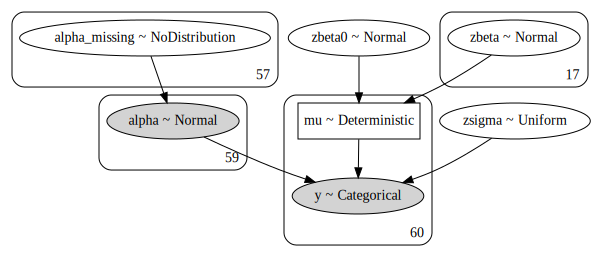

In [28]:
from scipy.stats import logistic

@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.fmatrix])
def outcome_probabilities(alpha, mu, sigma):
    out = np.empty((mu.size, nYlevels), dtype=np.float32)
    l = logistic(loc=mu,scale=sigma)
    
    for i in range(len(thresh)):
        if i == 0:
            out[:,i] = l.cdf(alpha[i])
        elif i == (len(thresh)-1):
            out[:,i] = 1 - l.cdf(alpha[(len(thresh)-1)])
        else:
            out[:,i] = np.max([np.repeat(0,mu.size), \
                               l.cdf(alpha[i]) - l.cdf(alpha[i-1])],\
                              axis=0)
    return out

with pm.Model() as ordinal_model:
    alpha = pm.Normal('alpha', mu=thresh, tau=np.repeat(1/2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)
    
    zbeta0 = pm.Normal('zbeta0', mu=(1+nYlevels)/2, tau=1/nYlevels**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1/nYlevels**2, shape=beta_Off_PCA.shape[1])    
    mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta,beta_Off_PCA.T.astype('float32')))
    
    zsigma = pm.Uniform('zsigma', nYlevels/1000.0, nYlevels*10.0)
    
    pr = outcome_probabilities(alpha, mu, zsigma)
    
    y = pm.Categorical('y', pr, observed=Y)
    
pm.model_to_graphviz(ordinal_model)
################################################################################################

In [37]:
# Run MCMC
np.random.seed(4747)
with ordinal_model:
    trace = pm.sample(3000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [zsigma]
>Slice: [zbeta]
>Slice: [zbeta0]
>Slice: [alpha_missing]
100%|████████████████████████████████████████████████████████████████████████████| 3500/3500 [4:37:10<00:00,  5.05s/it]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


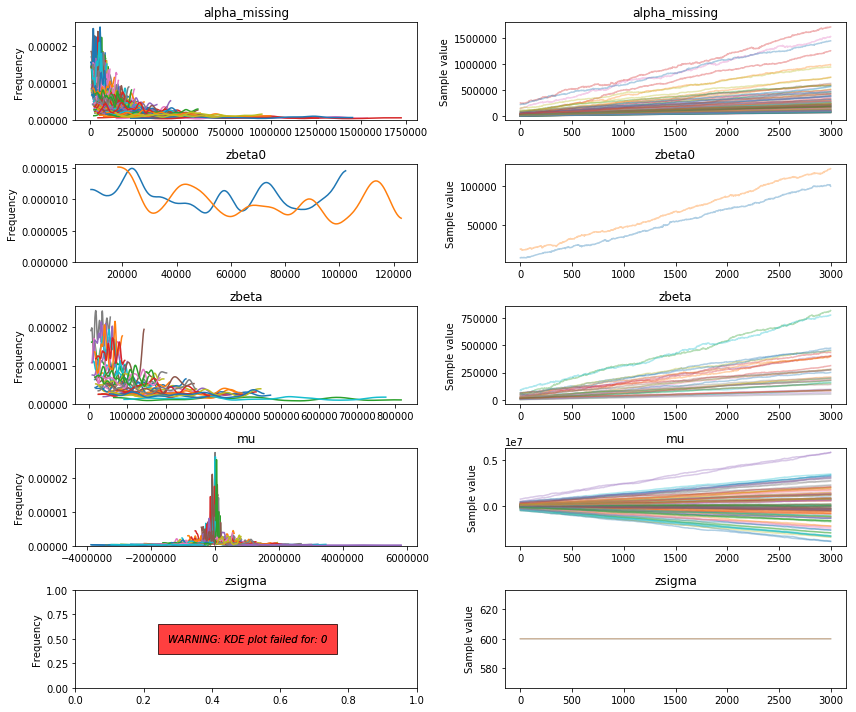

In [38]:
pm.traceplot(trace);

In [29]:
map_estimate = pm.find_MAP(model=ordinal_model)
print(map_estimate)

C:\Users\Christian\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -inf: 100%|███████████████████████████████████████████████████████████████████| 914/914 [00:13<00:00, 66.24it/s]


{'alpha_missing': array([ 5.08792896,  6.08792896,  7.08792896,  8.08792896,  9.08792896,
       10.08792896, 11.08792896, 12.08792896, 13.08792896, 14.08792896,
       15.08792896, 16.08792896, 17.08792896, 18.08792896, 19.08792896,
       20.08792896, 21.08792896, 22.08792896, 23.08792896, 24.08792896,
       25.08792896, 26.08792896, 27.08792896, 28.08792896, 29.08792896,
       30.08792896, 31.08792896, 32.08792896, 33.08792896, 34.08792896,
       35.08792896, 36.08792896, 37.08792896, 38.08792896, 39.08792896,
       40.08792896, 41.08792896, 42.08792896, 43.08792896, 44.08792896,
       45.08792896, 46.08792896, 47.08792896, 48.08792896, 49.08792896,
       50.08792896, 51.08792896, 52.08792896, 53.08792896, 54.08792896,
       55.08792896, 56.08792896, 57.08792896, 58.08792896, 59.08792896,
       60.08792896, 61.08792896]), 'zbeta0': array(33.08792896), 'zbeta': array([2.58792896, 2.58792896, 2.58792896, 2.58792896, 2.58792896,
       2.58792896, 2.58792896, 2.58792896, 2.5879

In [38]:
uniqueRank = rank_Off['rank'].unique()
nYlevels = len(uniqueRank)

#thresh = np.repeat(0, nYlevels)
thresh = np.arange(1.5, nYlevels, dtype=np.float32)
thresh_obs = np.ma.asarray(thresh, dtype=np.float32)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))
################################################################################################

thresh:		[ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5
 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5
 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5
 57.5 58.5 59.5]
thresh_obs:	[1.5 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- 59.5]


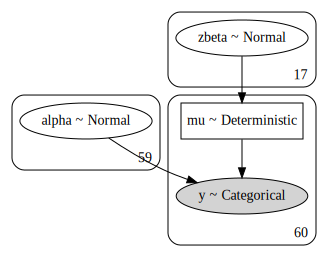

In [41]:
from scipy.stats import logistic

@as_op(itypes=[tt.dvector, tt.dvector], otypes=[tt.fmatrix])
def outcome_probabilities(alpha, mu):
    out = np.empty((mu.size, nYlevels), dtype=np.float32)
    l = logistic(loc=mu,scale=1)#,scale=sigma)
    
    for i in range(len(thresh)):
        if i == 0:
            out[:,i] = l.cdf(alpha[i])
        elif i == (len(thresh)-1):
            out[:,i] = 1 - l.cdf(alpha[(len(thresh)-1)])
        else:
            out[:,i] = np.max([np.repeat(0,mu.size), \
                               l.cdf(alpha[i]) - l.cdf(alpha[i-1])],\
                              axis=0)
    return out

with pm.Model() as ordinal_model:
    alpha = pm.Normal('alpha', mu=thresh, tau=np.repeat(1/2**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs)
    
    #zbeta0 = pm.Normal('zbeta0', mu=(1+nYlevels)/2, tau=1/nYlevels**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1/nYlevels**2, shape=beta_Off_PCA.shape[1])    
    #mu = pm.Deterministic('mu', zbeta0 + pm.math.dot(zbeta,beta_Off_PCA.T.astype('float32')))
    mu = pm.Deterministic('mu', pm.math.dot(zbeta,beta_Off_PCA.T.astype('float32')))
    
    #zsigma = pm.Uniform('zsigma', nYlevels/1000.0, nYlevels*10.0)
    
    #pr = outcome_probabilities(alpha, mu, zsigma)
    pr = outcome_probabilities(alpha, mu)
    
    y = pm.Categorical('y', pr, observed=Y)
    
pm.model_to_graphviz(ordinal_model)
##############################################################################################

In [42]:
# Run MCMC
with ordinal_model:
    trace = pm.sample(3000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [zbeta]
>Slice: [alpha]
  0%|                                                                                         | 0/3500 [00:00<?, ?it/s]


ValueError: Sampling stopped before a sample was created.

In [43]:
map_estimate = pm.find_MAP(model=ordinal_model)
print(map_estimate)

C:\Users\Christian\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -inf: 100%|███████████████████████████████████████████████████████████████████| 914/914 [00:23<00:00, 38.55it/s]


{'alpha': array([ 4.08792896,  5.08792896,  6.08792896,  7.08792896,  8.08792896,
        9.08792896, 10.08792896, 11.08792896, 12.08792896, 13.08792896,
       14.08792896, 15.08792896, 16.08792896, 17.08792896, 18.08792896,
       19.08792896, 20.08792896, 21.08792896, 22.08792896, 23.08792896,
       24.08792896, 25.08792896, 26.08792896, 27.08792896, 28.08792896,
       29.08792896, 30.08792896, 31.08792896, 32.08792896, 33.08792896,
       34.08792896, 35.08792896, 36.08792896, 37.08792896, 38.08792896,
       39.08792896, 40.08792896, 41.08792896, 42.08792896, 43.08792896,
       44.08792896, 45.08792896, 46.08792896, 47.08792896, 48.08792896,
       49.08792896, 50.08792896, 51.08792896, 52.08792896, 53.08792896,
       54.08792896, 55.08792896, 56.08792896, 57.08792896, 58.08792896,
       59.08792896, 60.08792896, 61.08792896, 62.08792896]), 'zbeta': array([2.58792896, 2.58792896, 2.58792896, 2.58792896, 2.58792896,
       2.58792896, 2.58792896, 2.58792896, 2.58792896, 2.5879